# Algorithmic lattice surgery example: CNOTs with phases.

In this notebook, we will demonstrate the process of undertaking algorithmic lattice surgery and transfering phases from the original PyZX graph to the space-time diagram produced by the algorithm.

In [1]:
import os
import sys
import pyzx as zx
from pathlib import Path

repository_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
output_folder_path = f"{repository_root}/outputs/txt"
if repository_root not in sys.path:
    sys.path.insert(0, repository_root)

from scripts.runner import runner
from utils.interop_pyzx import get_simple_graph_from_pyzx

zx.settings.colors = zx.rgb_colors
%matplotlib widget

## Input: Preparing and distilling a ZX graph

### Preparing a PyZX Graph

Let's start by preparing a PyZX graph. We'll use a graph is specifically designed to ensure the edges of the spiders with phases are treated differently by the algorithm.
- Most edges in this graph will be treated as simple placements. The algorithm uses the edge to discover a new spider, then places the spider in the 3D spage. Again. And Again. These operations are simpler and typically involve direct connections between the 3D blocks corresponding to the original spiders.
- However, by the time the algorithm reaches the edge between spiders 6 and 7, these spiders have already been assigned a position in the 3D space and a 3D kind. This is a more complex operation. The algorithm needs to add intermediary nodes to be able to complete the edge between them.

These are the two modes used by the algorithm to create topologically-correct space-time diagrams: path creation and path discovery.

The point of using this graph is to demonstrate later in the notebook that the process to recover phases is the same irrespective of how the algorithm treats a given spider and its edges.

In [2]:
from fractions import Fraction
from pyzx.utils import EdgeType

circuit_name = "C_w_phases"

c = zx.Circuit(3)
c.add_gate("ZPhase", 0, phase=Fraction(1,2))
c.add_gate("CNOT", 0, 2)
c.add_gate("CNOT", 1, 2)
c.add_gate("ZPhase", 1, phase=Fraction(1,1))
c.add_gate("ZPhase", 2, phase=Fraction(1,4))

pyzx_graph = c.to_graph()
pyzx_graph.add_edge(edge_pair=(8,5),  edgetype=EdgeType.SIMPLE)
pyzx_graph.add_to_phase(vertex=7, phase=Fraction(1/2))

zx.draw(pyzx_graph, labels=True)

### Distilling the PyZX graph into a simpler graph that the algorithm can consume

The PyZX graph has information that the algorithm does not need to places the spiders in the 3D space. So, before feeding it into the algorithm, we will distill the PyZX graph into a `simple_graph`, i.e., a dictionary of nodes and edges. 

There is a single instruction that achieves this by undertaking all steps below:
- Dump the entire PyZX graph into a dictionary using PyZX internal methods,
- Transform into a dictionary with clear syntax for 3D positioning but all values zeroed out,
- Distill the 3D dictionary into a simpler dictionary for consumption by the algorithm.

In [3]:
simple_graph = get_simple_graph_from_pyzx(pyzx_graph)
print(simple_graph)

{'nodes': [(0, 'O'), (1, 'O'), (2, 'O'), (3, 'Z'), (4, 'X'), (5, 'Z'), (6, 'X'), (7, 'Z'), (8, 'Z'), (9, 'Z'), (10, 'O'), (11, 'O'), (12, 'O')], 'edges': [((0, 3), 'SIMPLE'), ((1, 7), 'SIMPLE'), ((2, 4), 'SIMPLE'), ((3, 5), 'SIMPLE'), ((4, 5), 'SIMPLE'), ((4, 6), 'SIMPLE'), ((5, 10), 'SIMPLE'), ((5, 8), 'SIMPLE'), ((6, 7), 'SIMPLE'), ((6, 9), 'SIMPLE'), ((7, 8), 'SIMPLE'), ((8, 11), 'SIMPLE'), ((9, 12), 'SIMPLE')]}


It is possible to see from the printout that the `simple_graph` no longer has information about phases. There is no need to worry about this. The algorithm does not need additional information to carry out its foundational operations, and we will recover this information later in the process.

## Process: Running the algorithm

The next step is to feed the `simple_graph` to the algorithm and let it work its magic (it's not magic, but let's pretend it is). This can be achieved with a single command that gets the entire process running and produces a number of outputs that give insight into the process and the final space-time diagram resulting from the algorithmic lattice surgery.

The algorithm will run up to ten times.
- If a run is unsuccessful, it will throw away the run and start again.
- If a run is successful, the algorithm will return a number of objects for further use (we'll look at them closer later in the notebook) and produce:
  - an animation with key stages of the process, saved to `./outputs/media/`,
  - a detailed node-by-node/edge-by-edge printout of results, saved to `./outputs/txt/`,
  - and an interactive visualisation, displayed on screen.

To better understand the process, the code below prints the PyZX graph before running the algorithm. Look at the nodes closely and compare with the updates by the algorithm.

The algorithm picks a node with a high number of edges as starting point and places it in the 3D space. It then places the neighbours of this node. After, it takes one of the neighbours and place its neighbours. And so forth until it runs out of nodes. Each update highlights the order in which nodes are placed with IDs corresponding to the IDs of the original PyZX graph.

**Note 1.** There is a `max_attempts=1` optional parameter in the runner function. You might need to run the code several times to get a final successful result. The standard `max_iter` is 10 to give the algorithm a few chances of finding a solution. That said, the limit in this Jupyter notebook is of only one iteration because the notebook will show step-by-step visualisations of the entire process. This would be confusing if the algorithm iterates more than once automatically.

**Note 2.** The final visualisation is an interactive 3D panel. You can turn them around to examine the results from all directions.



#################################################### 
STARTING ALGORITHM FROM CLEAN SLATE 
Attempt 1 
####################################################

Placing first node.
5: ((0, 0, 0) 'zzx').

Creating path. Node ID (source): 5 ((0, 0, 0), 'zzx') --> Node ID (target): 3 ((?, ?, ?), ???) (ZX type: Z)
Original ZX type for edge: SIMPLE
8 viable paths created. Algorithm picks best..xx.xx.x..x..x
Chosen path: [((0, 0, 0), 'Z'), 'SIMPLE EDGE', ((3, 0, 0), 'Z')]

Creating path. Node ID (source): 5 ((0, 0, 0), 'zzx') --> Node ID (target): 4 ((?, ?, ?), ???) (ZX type: X)
Original ZX type for edge: SIMPLE
11 viable paths created. Algorithm picks best..x........
Chosen path: [((0, 0, 0), 'Z'), 'SIMPLE EDGE', ((-3, 0, 0), 'X')]

Creating path. Node ID (source): 5 ((0, 0, 0), 'zzx') --> Node ID (target): 10 ((?, ?, ?), ???) (ZX type: O)
Original ZX type for edge: SIMPLE
4 viable paths created. Algorithm picks best.
Chosen path: [((0, 0, 0), 'Z'), 'SIMPLE EDGE', ((0, 3, 0), 'BOUNDARY')]

Cre

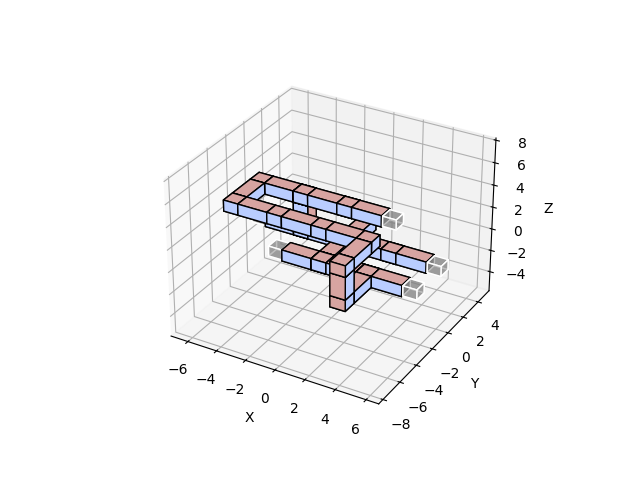

Animation saved to C:\Users\polyz\Documents\drj\4_projects\algorithmic_lattice_surgery\outputs\media/C_w_phases.gif


In [4]:
# Define weights for the value function to to choose best of several valid paths per each edge based on: (length of path, number of beams broken by path)
# A negative value for length of path favours short paths.
# A negative value for number of beams broken by path favours placements that do not block potential open faces requiring connections.
VALUE_FUNCTION_HYPERPARAMS = (-1, -0.5)

# Define a desired length of beams
# The longer the beams, the more space between faces. This feature needs improvement but, in theory, increases the odds of success.
# Needs to be combined with an equal or larger `MAX_PATHFINDER_SEARCH_SPACE`
LENGTH_OF_BEAMS = 3

# Define the maximum size of the search space (distance between source and target node for each pathfinding iteration)
# Larger values will produce a larger number of paths, and longer paths. This increases the odds of a successful result, with a significant impact on runtime.
MAX_PATHFINDER_SEARCH_SPACE = 3

kwargs = {
    "weights": VALUE_FUNCTION_HYPERPARAMS,
    "length_of_beams": LENGTH_OF_BEAMS,
    "max_search_space": MAX_PATHFINDER_SEARCH_SPACE,
}

zx.draw(pyzx_graph, labels=True)

simple_graph_after_use, edge_paths, lattice_nodes, lattice_edges = runner(
    simple_graph, circuit_name, strip_boundaries=False, hide_boundaries=False, max_attempts=1, visualise="final", **kwargs
)

## Output: Using outputs

The algorithm returns four objects:
- `simple_graph_after_use`: the original `simple_graph` returned for convenience.
- `edge_paths`: a set of 3D edges where each edge corresponds to the original edges in the ZX graph but where the "nodes" have been exchanged for all 3D blocks and pipes needed to clear the edge in a 3D space (contains redundant nodes across edges).
- `lattice_nodes`: all nodes in `edge_paths` distilled into a single object with no redundant nodes.
- `lattice_edges`: all edges in `edge_paths` distilled into a single object with no redundant edges.

These objects can be used variously.

For example, a helpful first operation is to visualise the relation between the original PyZX graph and the results of the algorithm by printing the graph alongside a summary of how the algorithm rendered each edge.
- Short edges containing a three step combination of block-pipe-block or node-edge-node are edges that the algorithm was able to clear easily by simply placing the next node.
- Long edges containing more than three items total correspond to edges the algorithm had to break into several segments to be able to clear the edge in the 3D space.

In [5]:
from utils.utils_zx_graphs import get_zx_type_from_kind
zx.draw(pyzx_graph, labels=True)

if edge_paths:
    for key, edge in edge_paths.items():
        block_by_block = []
        nodes_and_edges = []
        for node in edge["path_nodes"]:
            block_by_block.append(node[1])
            nodes_and_edges.append(get_zx_type_from_kind(node[1]))
        print(f"{key}: {"-".join(block_by_block)} ({" - ".join(nodes_and_edges)})")

(3, 5): zzx-ozx-zzx (Z - SIMPLE - Z)
(4, 5): zzx-ozx-xzx (Z - SIMPLE - X)
(5, 10): zzx-zox-ooo (Z - SIMPLE - BOUNDARY)
(5, 8): zzx-zox-zzx (Z - SIMPLE - Z)
(0, 3): zzx-ozx-ooo (Z - SIMPLE - BOUNDARY)
(2, 4): xzx-ozx-ooo (X - SIMPLE - BOUNDARY)
(4, 6): xzx-xzo-xzx (X - SIMPLE - X)
(7, 8): zzx-ozx-zzx (Z - SIMPLE - Z)
(8, 11): zzx-ozx-ooo (Z - SIMPLE - BOUNDARY)
(6, 9): xzx-ozx-zzx (X - SIMPLE - Z)
(1, 7): zzx-ozx-ooo (Z - SIMPLE - BOUNDARY)
(9, 12): zzx-ozx-ooo (Z - SIMPLE - BOUNDARY)
(6, 7): xzx-ozx-zzx-zox-zzx-ozx-xzx-ozx-xzx-ozx-zzx-zox-zxx-zxo-zxx-zox-zzx (X - SIMPLE - Z - SIMPLE - Z - SIMPLE - X - SIMPLE - X - SIMPLE - Z - SIMPLE - X - SIMPLE - X - SIMPLE - Z)


We can also apply the phases in the original PyZX graph to the results of the algorithm. 

For this, let's get the information about the phases of all spiders in the original PyZX graph and assign this information to a variable `map_of_phases`.

The algorithm maintains the IDs of any nodes/blocks present in the original PyZX graph. In other words, the entries in `lattice_nodes` with an ID also present in `map_of_phases` correspond to the same node/spider/block.

We can therefore create a new object `lattice_nodes_with_phases` by combining the information in `map_of_phases` and `lattice_nodes`.

In [6]:
map_of_phases = pyzx_graph.phases()
lattice_nodes_extended = {}

if lattice_nodes:
    for id, node in lattice_nodes.items():
        position, kind = node
        phase = map_of_phases[id] if id in map_of_phases.keys() else 0
        lattice_nodes_extended[id] = (position, kind, phase)

The correctness of the final object can be gauged by comparing the original PyZX graph with the `lattice_nodes_extended` objects. The phases of blocks/spiders present in both the original ZX graph and `lattice_nodes_extended` should be the same, and all other nodes should have no phase.

In [7]:
zx.draw(pyzx_graph, labels=True)

for id, node in lattice_nodes_extended.items():
    print(f"{id}: {node}")

5: ((0, 0, 0), 'zzx', 0)
3: ((3, 0, 0), 'zzx', Fraction(1, 2))
4: ((-3, 0, 0), 'xzx', 0)
10: ((0, 3, 0), 'ooo', 0)
8: ((0, -3, 0), 'zzx', Fraction(1, 1))
0: ((6, 0, 0), 'ooo', 0)
2: ((-6, 0, 0), 'ooo', 0)
6: ((-3, 0, 3), 'xzx', 0)
7: ((3, -3, 0), 'zzx', Fraction(1, 2))
11: ((-3, -3, 0), 'ooo', 0)
9: ((0, 0, 3), 'zzx', Fraction(1, 4))
1: ((6, -3, 0), 'ooo', 0)
12: ((3, 0, 3), 'ooo', 0)
26: ((-6, 0, 3), 'zzx', 0)
28: ((-6, -3, 3), 'zzx', 0)
30: ((-3, -3, 3), 'xzx', 0)
32: ((0, -3, 3), 'xzx', 0)
34: ((3, -3, 3), 'zzx', 0)
36: ((3, -6, 3), 'zxx', 0)
38: ((3, -6, 0), 'zxx', 0)


Having confirmed it's correctness, we can now append `lattice_nodes_extended` to the results printed by the algorithm. 

In [8]:
if lattice_nodes_extended and lattice_edges:
    lines = []
    lines.append(
        "\n__________________________\nLATTICE SURGERY EXTENDED (Graph + Phases)\n"
    )
    for key, node in lattice_nodes_extended.items():
        lines.append(f"Node ID: {key}. Info: {node}\n")
    for key, edge_type in lattice_edges.items():
        lines.append(f"Edge ID: {key}. Info: {edge_type} \n")

    Path(output_folder_path).mkdir(parents=True, exist_ok=True)
    with open(f"{output_folder_path}/{circuit_name}.txt", "a") as f:
        f.writelines(lines)
        f.close()

    print(f"Result saved to: {output_folder_path}/{circuit_name}.txt")

Result saved to: c:\Users\polyz\Documents\drj\4_projects\algorithmic_lattice_surgery/outputs/txt/C_w_phases.txt
